# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve 
from tqdm.auto import tqdm
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data = data.fillna(0)

In [5]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
data_ohe = pd.get_dummies(data.drop(['Surname', 'RowNumber','CustomerId'], axis=1), drop_first=True)
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'] , axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, stratify=target, 
                                                                              test_size=0.4, random_state=12345)

In [7]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, 
                                                                              stratify=target_valid, test_size=0.5, 
                                                                              random_state=12345)

In [8]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [9]:
data_ohe.NumOfProducts.value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

In [10]:
data_ohe.Tenure.value_counts()

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: Tenure, dtype: int64

In [11]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
scaler.fit(features_valid[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
scaler.fit(features_test[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


### Вывод

- В столбце `Tenure` есть пропуски, заменим их на 0.
- Преобразовали данные техникой OHE.
- Разбили данные на 3 выборки: train 60%, valid 20% и test 20%.
- Стандартизировали данные в столбцах `CreditScore`, `Age`, `Balance` и `EstimatedSalary`.

## Исследование задачи

In [12]:
target.mean()

0.2037

Есть дисбаланс классов 20%:80%.

In [13]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in tqdm(range(10, 101, 10)):
    for depth in range(2, 16, 1):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model_forest = model
            best_result = result
            best_est = est
            best_depth = depth
print("F1 наилучшей модели случайного леса:", round(best_result, 3),
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)


F1 наилучшей модели случайного леса: 0.617 Количество деревьев: 40 Максимальная глубина: 14


In [14]:
for depth in range(2, 11, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print((f1_score(target_valid, predicted_valid)), ('depth = ' + str(depth)))

0.5203488372093023 depth = 2
0.5375722543352601 depth = 3
0.5174603174603174 depth = 4
0.5431309904153354 depth = 5
0.5735963581183613 depth = 6
0.5950653120464441 depth = 7
0.5718654434250764 depth = 8
0.564327485380117 depth = 9
0.5555555555555556 depth = 10


In [15]:
model = LogisticRegression(solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print((f1_score(target_valid, predicted_valid)))

0.3076923076923077


### Вывод

- Есть дисбаланс классов 20%:80%.
- Без учёта дисбаланса модель случайного леса показала себя лучше всего при количество деревьев 40 и максимальной глубине 14, F1 = 0.617.

## Борьба с дисбалансом

### Увеличение выборки

In [16]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [17]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [18]:
target_upsampled.mean()

0.5056900475894889

In [19]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in tqdm(range(10, 61, 10)):
    for depth in range(1, 12, 1):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model_forest = model
            best_result = result
            best_est = est
            best_depth = depth
print("F1 наилучшей модели случайного леса на валидационной выборке:", round(best_result, 3),
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)


F1 наилучшей модели случайного леса на валидационной выборке: 0.644 Количество деревьев: 60 Максимальная глубина: 11


In [20]:
for depth in range(2, 11, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print((f1_score(target_valid, predicted_valid)), ('depth = ' + str(depth)))

0.49801113762927607 depth = 2
0.49801113762927607 depth = 3
0.5596412556053811 depth = 4
0.5525672371638142 depth = 5
0.5769944341372912 depth = 6
0.5768535262206148 depth = 7
0.5504087193460492 depth = 8
0.5406976744186046 depth = 9
0.5326732673267327 depth = 10


In [21]:
model = LogisticRegression(solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print((f1_score(target_valid, predicted_valid)))

0.5233160621761659


### Уменьшение выборки

In [22]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [23]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [24]:
target_downsampled.mean()

0.5057947019867549

In [25]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in tqdm(range(10, 71, 10)):
    for depth in range(1, 10, 1):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model_forest = model
            best_result = result
            best_est = est
            best_depth = depth
print("F1 наилучшей модели случайного леса на валидационной выборке:", round(best_result, 3),
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)


F1 наилучшей модели случайного леса на валидационной выборке: 0.633 Количество деревьев: 70 Максимальная глубина: 8


In [26]:
for depth in range(2, 11, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    print((f1_score(target_valid, predicted_valid)), ('depth = ' + str(depth)))

0.49801113762927607 depth = 2
0.49801113762927607 depth = 3
0.560931899641577 depth = 4
0.5527559055118111 depth = 5
0.5928030303030303 depth = 6
0.5833333333333334 depth = 7
0.5642458100558659 depth = 8
0.559928443649374 depth = 9
0.5477252453166815 depth = 10


In [27]:
model = LogisticRegression(solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print((f1_score(target_valid, predicted_valid)))

0.526225279449699


### Вывод

Учитывая дисбаланс классов, при увеличение выборки удалось добиться улучшите качество модели случайного леса F1 = 0.644, а при уменьшение выборки F1 = 0.633 на валидационной выборке.

## Тестирование модели

### Увеличение выборки

In [28]:
features_upsampled, target_upsampled = upsample(pd.concat([features_train, features_valid]), 
                                                pd.concat([target_train, target_valid]), 4)

In [29]:
target_upsampled.mean()

0.5058184639255237

In [30]:
model = RandomForestClassifier(n_estimators=60, max_depth=11, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print(f1_score(target_test, predicted_test))

0.6153846153846153


In [31]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)

0.8546636004263123


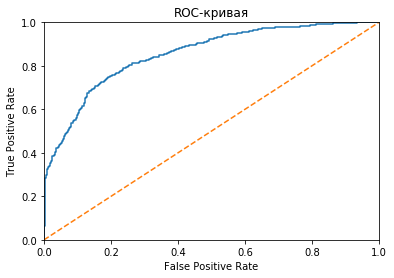

In [32]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')

### Уменьшение выборки

In [33]:
features_downsampled, target_downsampled = downsample(pd.concat([features_train, features_valid]), 
                                                      pd.concat([target_train, target_valid]), 0.25)

In [34]:
target_downsampled.mean()

0.5058969584109249

In [35]:
model = RandomForestClassifier(n_estimators=70, max_depth=8, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
print(f1_score(target_test, predicted_test))

0.5814393939393939


In [36]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)

0.8529345986973106


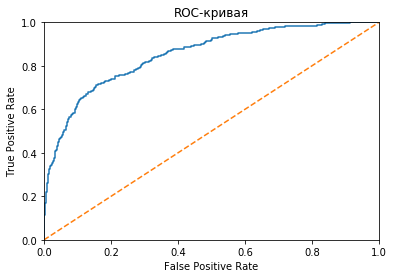

In [37]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')

### Вывод

- Есть дисбаланс классов 20%:80%.
- Без учёта дисбаланса модель случайного леса показала себя лучше всего при количество деревьев 40 и максимальной глубине 14, F1 = 0.617.
- Учитывая дисбаланс классов, при увеличение выборки удалось добиться улучшите качество модели случайного леса F1 = 0.644, а при уменьшение выборки F1 = 0.633 на валидационной выборке.
- На тестовой выборке лучший результат получился при увеличение выборки F1 = 0.615.
- По графику ROC-кривой видно что наша модель сильно отличается от случайной.